# MA 591: Final Project

Clustering on NLP Datasets

Jessica Mele


# Introduction:

Clustering is a category of unsupervised learning techniques used to discover some underlying features or hidden structures of a dataset. Clustering techniques rely on the defitions of similarity and differences among instances in the data. The overarching goal of clustering is to unveil a natural grouping in a dataset such that:

- Instances grouped to the same cluster are as similar as possible.
- Instances grouped to different clusters are as different as possible.

Some commonly used distance functions to define similarity and differences are Minkowski, Euclidean, Cosine and Pearson. Depending on the complexity of the data set one distance function might be more appropriate than others and so it is important to have a clear definition of distance measurements before implementing any clustering algorithm. [1]


There are different types of clustering algorithms based on: 
- Partition
- Heirarchy
- Fuzzy Theory
- Distribution
- Density
- Graph Theory
- Grid
- Fractal Theory
- Model


*Motivation:* This project will focus on analyzing the results from clustering based on **partition** on free-text datasets. With the increasing availability of electronic records, the ability to analyze free-text data is becoming even more important now more than ever. In particular, finding a way to classify the data is extremely important to researchers focused on creating predictive models. In most cases, there does not exist a list of ground truth labels and so an efficient clustering technique is essentail to faciliate the automation of classifying free-text data so that this information can be included in machine learning models. In particular, this project was interesting to me because my research is focused on creating predictive models and finding the best method to transform and include free-text data to improve prediction accuracy. 



# Methodology:
The standard process for clustering free-text data can be generalized by the following steps:

    

1. Data selection/extraction
2. Text pre-processing
3. Vectorization
4. If necessary, dimensionality reduction
5. Clustering
6. Evaluation and description in terms of the data        



## K-Means Clustering:

K-Means clustering is a type of partition clustering and the main idea relies on using the center points of data as the center of the cluster. The data then gets partitioned based on how "close" a point is to the center of the cluster. The algorithm works by iteratively updating the center of the cluster and re-assigning data points to a cluster until either a maximum number of iterations is reached or a tolerance level of change in the clusters is not met.  K-Means is widely used in clustering because it has linear time complexity and in general is very efficient if certain assumptions are met.

One of the drawbacks of K-Means Clustering are the assumptions that you know how many clusters exist within the data and that the data is actually separable meaning that there exists no overlap between clusters. Another drawback is that the distance between data points and their respective centers is computed using the Euclidean distance which is sensitive to high-dimensional data, meaning that this metric can "explode" in higher dimensions ultimately yielding a poor cluster performance. [2]

The iterative method can best be summed up by:

1. Pick a starting set of center points (optimized methods determine the best starting points) and 
2. Assign each element in the dataset to a cluster defined by the center point.
3. Update the center of the cluster to be the center of the data points in the cluster. 
4. Repeat the 2nd and 3rd steps until a maximum number of iterations is reached or there is a barely noticeable update between cluster assignments. [2]


To help combat some of the above assumptions we have the elbow method to help determine the optimal number of clusters and the Python package SciKit-Learn utilizes a method K-Means++ to help determine optimal starting points to assist with iterative convergence to the optimal clustering. The elbow method utilizes a metric called 'inertia' which is the Sum of Squared Errors (SSEs) of each point in the cluster to it's respective center point. The goal is find the number of clusters in which the distortion/inertia begins to increase most rapidly. K-Means++ iteratively finds the best starting center points by creating a set of center points and assigning each data point a weighted probability given by the sum of the squared distance of each remaining data point to the current center points to determine whether or not it will be included in the set of center points. Then, the algorithm proceeds with regular K-Means. [2]

In [1]:
#Load necessary packages
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text as txt
#from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import cm 
from sklearn.metrics import silhouette_samples
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import classification_report

nltk.download('wordnet')
nltk.download('stopwords')

#Some code to beautify the plots
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


[nltk_data] Downloading package wordnet to /home/jessica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jessica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Implementation:
## Loading the data set.

SciKit Learn has a few datasets available for downloading to use with their machine learning packages. While searching for NLP datasets I came across one called **20 NewsGroups**. This dataset is comprised of a collection of newsgroup documents from 20 different categories. It was recommended on the website to load the data without headers, footers and quotes to make the data more realistic. In order to avoid memory allocation errors and be able to showcase the clustering performance I loaded text from three very different categories: comp.windows.x, soc.religion.christian and rec.motorcycles.

In [2]:

#'alt.atheism', 'talk.politics.guns', 'sci.med'

categories = ['comp.windows.x', 'soc.religion.christian','rec.motorcycles'] #specify 3 categories for implementation
data_20newsgroups_train = fetch_20newsgroups(subset = 'train', remove = ('headers','footers','quotes'), \
                                             categories = categories,shuffle = True, random_state = 42)
#data_20newsgroups_test = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

#stop_words = txt.ENGLISH_STOP_WORDS #load stop words

#takes a while to run, only run once


## Text pre-processing:

For every element in the dataset we need to process it by removing stop words, numbers, and any more irrelevant information to try to reduce the number of features and normalize the data set. The below method @text_process takes in a string as an argument and removes punctuation and numbers. It also normalizes all of the words in the string to lower case. Then, a lemmatizer is used to create tokens of the roots of each word. This further reduces the number of features by only considering the root of each word and words with the same roots will be categorized the same. Then, the function returns a list of processed tokens.

In [3]:
#Processing text
def text_process(text):
    '''
    Takes in a string argument and transforms it by removing predefined stop words, punctuation, digits and\
    unimportant characters - lemmatization.
    Inputs: text: string to process
    Output: A list of tokens, roots only, without punctuation.
    
    Reference: #https://medium.com/@rohithramesh1991/unsupervised-text-clustering \
    -using-natural-language-processing-nlp-1a8bc18b048d
    '''
    
    
    stemmer = WordNetLemmatizer() #lemmatization object
    temp = [char for char in text if char not in string.punctuation] #create a list of characters that are not punctuation
    temp = ''.join([i for i in temp if not i.isdigit()])  #appends characters that are not digits
    temp = [word.lower() for word in temp.split() if word not in stopwords.words('english')] #transforms all words to lower case to normalize
    return [stemmer.lemmatize(word) for word in temp] #lemmatize takes the roots and the set returns unique tokens
    

## Vectorization:
Now we need to take the processed text and transform them into something recognizable by the computer. This is called vectorization. The TfidfVectorizer object from SciKit-Learn converts a collection of raw documents to a matrix of TF-IDF features. The TF-IDF features include a 'vocabulary' of words from the documents and assigns a value related to the frequency of each word in the respective documents. The less frequent a word is the higher the TF-IDF value, meaning the more unique a word is in the document the greater weight is assigned to it for clustering purposes. It is important to note that the result of the fit_transform of this Object on the data set returns a large sparse matrix of TF-IDF values for each document.

In [4]:

train_data = data_20newsgroups_train.data
#targets = train_data.target


vectorizer = TfidfVectorizer(analyzer = text_process, ngram_range =(1, 3)) #create vectorizer object
vectors_train = vectorizer.fit_transform(train_data) #returns a sparse data set



print(vectors_train.shape)
vectors_train_arr = vectors_train.toarray() #transform from sparse matrix to dense array




(1790, 21989)


## Dimensionality Reduction:

The above TF-IDF transform results in a sparse matrix of size (1790,21989) which means that there are 1790 documents in the set and 21951 features after the vectorization. This is an extremely high dimensionality which will make K-Means more difficult to visualize as well as implement. The goal here is to find a projection of the data into a space of lower dimensionality. I tried three methods: SparsePCA, truncatedSVD and t-SNE. After evaluation of K-Means model performance and run-time I found that t-SNE is the preferred method for this dataset. t-SNE is t-Distributed Stochastic Neighbor Embedding. This method implements a nonlinear dimensionality reduction and is known to be successful in reducing high dimensional data into much lower spaces of 2 or 3 dimensions. Here, 2 dimensions is sufficient and allows me to showcase the results of the clustering algorithm. You can see from the below graph that even after the transformation there doesn't look like a good separation between the data points in this space. At least, it does not appear intuitive from this graph. Let's proceed to evaluate how well K-Means performs.

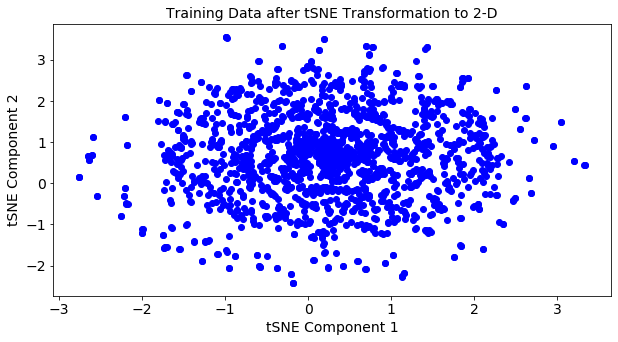

In [5]:
#from sklearn.decomposition import TruncatedSVD

'''
PCA = SparsePCA(n_components = 2)
PCA_train = PCA.fit_transform(vectors_train_arr)

'''

tsne = TSNE(n_components = 2)
TSNE_train = tsne.fit_transform(vectors_train_arr)


#tSVD = TruncatedSVD(n_components = 200)
#tSVD_train = tSVD.fit_transform(vectors_train)
plt.figure()
plt.scatter(TSNE_train[:,0], TSNE_train[:,1], color = 'blue')
plt.title('Training Data after tSNE Transformation to 2-D', size = 14)
plt.xlabel('tSNE Component 1', size = 14)
plt.ylabel('tSNE Component 2', size = 14)
plt.show()


## Clustering:

**Finding the optimal number of clusters:** 
Now, I know from pre-loading the dataset that the number of clusters that should exist in this loaded dataset is 3. Let's utilize the elbow method and observe whether this method illustrates that the optimal number of clusters for this dataset is in fact 3. Recall from above that we are looking for the point in which the distoration begins to increase the most rapidly. Here, that is around number of clusters = 3 and we can confirm that this is the number we will use for K-Means clustering.

### Finding the optimal number of clusters:

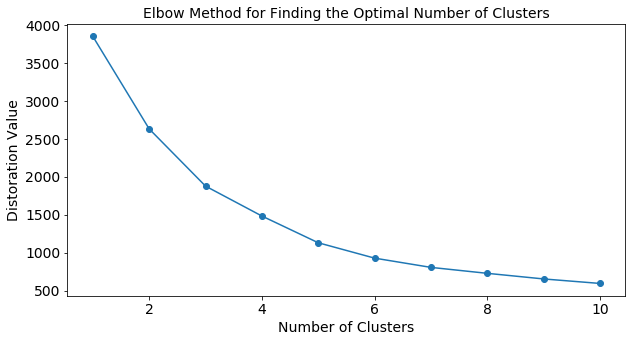

In [6]:

#how many clusters k should we have (optimal k using inertia)
#print(KMeans.inertia_) #trying different values 
inertias=[]
X = TSNE_train #vectors_train
max_nc = 11

for k in np.arange(1,max_nc): 
    temp = KMeans(n_clusters=k,random_state=0) 
    temp.fit(X) 
    inertias.append(temp.inertia_) 
    #print(k)
    
x_axis = np.arange(1,max_nc) 
plt.figure()
plt.plot(x_axis,inertias,marker='o') 
plt.xlabel('Number of Clusters', size = 14) 
plt.ylabel('Distoration Value', size = 14) 
plt.title('Elbow Method for Finding the Optimal Number of Clusters', size = 14) 
plt.show() 

### Fitting a K-Means Model to the data:
Here we build a KMeans object with the optimal number of clusters found above. The initial starting point is given by 'k-means++' which means that we will iteratively solve for the best center points of each cluster before proceeding with the  k-means algorithm. The maximum number of iterations is 500 with a specific tolerance of 0.00001. The fit_predict function assigns each element in the dataset to a cluster with a specified label.

In [7]:
n_clusters = 3

km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 500, tol = 0.00001)
#db = DBSCAN(min_samples = 5, eps = .5)
km1 = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 500, tol = 0.00001)
km1.fit(TSNE_train)
print(len(vectors_train_arr))

#don't delete this
fit_20news = km.fit_predict(vectors_train)
print(len(fit_20news))
#fit_pca = km.fit_predict(PCA_train)
fit_tsne = km.fit_predict(TSNE_train)


1790
1790


# Results and Testing:

In [8]:

#predict_PCA = fit_pca
#print(len(fit_20news))
print("Label distributions with no dimensionality reduction:")
print("First 20:", fit_20news[:20])
print("Bin count:", np.bincount(fit_20news))
print()
#print(predict_PCA[:20])
#print(np.bincount(predict_PCA))
print("Label distributions with t-SNE dimensionality reduction:")
print("First 20:", fit_tsne[:20])
print("Bin count:", np.bincount(fit_tsne))
print()
print("True label distributions:")
print("First 20:", data_20newsgroups_train.target[:20])
print("Bin count:", np.bincount(data_20newsgroups_train.target))
#print(fit_tSVD[:20])
#print(np.bincount(fit_tSVD))
#print(fit_20news_DB[:200])
#print(np.bincount(fit_20news_DB))


Label distributions with no dimensionality reduction:
First 20: [1 0 2 0 0 2 0 2 0 0 1 1 0 2 2 0 0 2 0 0]
Bin count: [979 403 408]

Label distributions with t-SNE dimensionality reduction:
First 20: [2 0 0 0 1 0 1 0 0 0 2 1 1 0 0 0 1 0 0 0]
Bin count: [812 515 463]

True label distributions:
First 20: [0 1 2 0 1 2 1 2 0 2 0 0 1 2 2 1 1 2 2 1]
Bin count: [593 598 599]


## Viewing the results of clustering in the 2-dimensional t-SNE component space:

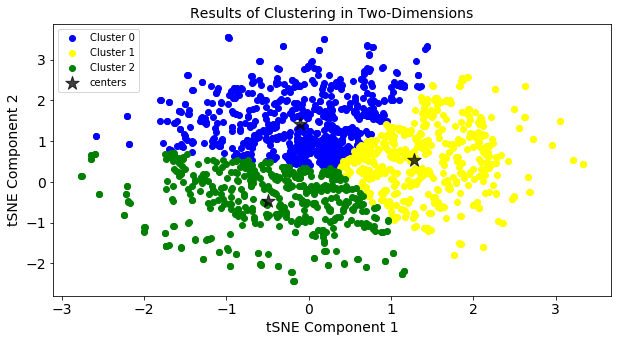

In [9]:

fig,ax = plt.subplots()
#plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
#ax.scatter(TSNE_train[:,0], TSNE_train[:, 1], c = fit_tsne, cmap ='viridis', label = 'viridis')
ax.scatter(TSNE_train[fit_tsne == 0,0], TSNE_train[fit_tsne==0,1], color = 'blue', label = 'Cluster 0')
ax.scatter(TSNE_train[fit_tsne == 1,0], TSNE_train[fit_tsne==1,1], color = 'yellow', label = 'Cluster 1')
ax.scatter(TSNE_train[fit_tsne == 2,0], TSNE_train[fit_tsne==2,1], color = 'green', label = 'Cluster 2')
centers = km1.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', alpha= 0.75, marker = '*', s = 200,label = 'centers')
ax.legend()
plt.xlabel('tSNE Component 1', size = 14)
plt.ylabel('tSNE Component 2', size = 14)
plt.title('Results of Clustering in Two-Dimensions', size = 14)
plt.show()


#get_Sil(TSNE_train, fit_tsne)
#get_Sil(tSVD_train, fit_tSVD)

## Evaluation using Silhouettes:

Below we define a function that computes the Silhouette score and produces a graph showing silhouette vaues for every element in the dataset. Here it is important to note that Silhouette scores range from -1 to 1. The score is evaluated based on cluster cohesion, $a_i$ (average distance between a sample point and all other points in the same cluster) and cluster separation, $b_i$ (average distance between a sample point and all other points in the nearest cluster). The score for each instance in the dataset is computed by the following $S_i = \frac{b_i - a_i}{max\{b_i, a_i\}}$


In [10]:
#Evaluating KMeans Clustering
def get_Sil(X,y):
    '''
    Silhouette score evaluation on fitted KMeans clustering model.
    Inputs: X: type list, original data that we performed the clustering on
    y: type list, holds assigned clustering values
    
    Outputs: Silhouette score and a plot of all Silhoutte scores for every element in the dataset.
    
    Reference: Python Machine Learning - 2nd Edition, pg.517
    '''
    y_km = y
    cluster_labels=np.unique(y_km) 
    n_cluster=cluster_labels.shape[0]

    sil_vals=silhouette_samples(X,y_km,metric='euclidean')
    sil_score = np.mean(sil_vals)
    y_ax_lower,y_ax_upper= 0, 0 
    yticks=[]

    for i,c in enumerate(cluster_labels): 
        sil_v=sil_vals[y_km==c] 
        sil_v.sort() 
        y_ax_upper+=len(sil_v) 
        color=cm.jet(float(i)/n_cluster) 
        plt.barh(range(y_ax_lower,y_ax_upper),sil_v,height=1.0,color=color) 
        yticks.append((y_ax_lower + y_ax_upper) / 2.) 
        y_ax_lower += len(sil_v)
        
    plt.axvline(sil_score,ymin=0,ymax=y_ax_upper,color='red',linestyle="--") 
    plt.yticks(yticks, cluster_labels + 1) 
    plt.ylabel('Cluster', size = 14) 
    plt.xlabel('Silhouette Coefficients', size = 14)
    plt.title('Silhouette Coefficients By Cluster', size = 14)
    plt.show() 
    
    return sil_score

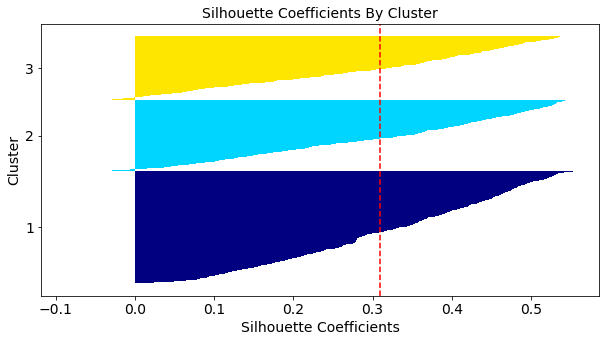

The Silhoutte Score is: 0.30947465


In [11]:
sil_score = get_Sil(TSNE_train, fit_tsne) #evaluate the clustering
print('The Silhoutte Score is:', sil_score)


### Using the true labels to re-label the clustered data:
**Confusion Matrix**

Using a majority rule approach, here we relabel the clustered data with their respective true labels. The idea behind this portion is to find the maximum bincount for each label in the data set. For example, the first row in the below matrix corresponds to the number of data points that were labeled as 0, 1, and 2 with the corresponding indices of the predicted values set to 0. This means we can relabel the data by taking the index of the largest element in the first row and use that to relabel our 0s in the predicted set.

In [12]:
targets = data_20newsgroups_train.target
for i in range(3):
    print(i, np.bincount(targets[fit_tsne == i]))

0 [ 64 165 583]
1 [ 81 421  13]
2 [448  12   3]


In [13]:
#re-labeling to match the true labels

def get_confusion(targets, predictedLabels):
    '''
    Re-labels the data based on the true label predictions, computes accuracy and gives confusion matrix.
    Input: Targets: list of true labels
    Predict: list of predicted cluster labels
    
    Return [acc, cm, predict]: Accuracy of the labeling and the confusion matrix and newly re-labeled data
    '''
    predict = predictedLabels
    
    numUnique = len(np.unique(predict))
    
    for i in range(numUnique):
        
        predict[predict == i] = np.argmax(np.bincount(targets[predict == i])) + numUnique 

    for c in range(len(targets)):
        predict[c] += -numUnique

    acc = np.mean(targets == predict)
    cm = confusion_matrix(targets, predict)
    
    return [acc, cm, predict]

def getResults(cm):
    '''
    Inputs: Array, confusion matrix dim n-classes by n-classes.
    Actual vs Predicted (rows vs columns)
    Teturns: TN, TP, FP, FN for each class 'ova' approach
    '''
    
    n = cm.shape[0]
    cc = 0
    results = np.zeros((n,4))
    
    for cc in range(n):
        TN = 0; TP = 0; FP = 0; FN = 0
        for i in range(n):
            for j in range(n):
                if j != cc and i != cc:
                    TN += cm[i][j]
                elif i == cc and j == cc:
                    TP += cm[i][j]
                elif i != cc and j == cc:
                    FP += cm[i][j]
                elif i == cc and j != cc:
                    FN += cm[i][j]
            
        results[cc][:] = [TN, TP, FP, FN]
        #cc += 1
    return results

def getMetrics(arr):
    '''
    Takes an array of nclasses with TN, TP, FP, FN for each row
    and prints the accuracy, precision, recall and F1 for each class
    Inputs: array of shape (nclasses, 4) with true negtives, true positives, false positives and false negatives
    Output: Data frame with accuracy, precision, recall and F1 score for each class in a one v all approach
    '''
    
    n = arr.shape[0]
    headers = ['Accuracy','Precision','Recall','F1']
    temp = []
    
    for i in range(n):
        TN = arr[i][0]; TP = arr[i][1]; FP = arr[i][2]; FN = arr[i][3]
        
        acc = (TN + TP)/(TN + FP + TP + FN)
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        F1 = 2*(precision*recall)/(precision + recall)
        
        '''
        print("Class:", i, "\nAcc:", "{:.3f}".format(acc), "\nPrecision:", \
              "{:.3f}".format(precision), "\nRecall:", "{:.3f}".format(recall), \
                  "\nF1:", "{:.3f}".format(F1)) 
        '''
        
        temp.append([format(acc, '.3f'), format(precision, '.3f'), format(recall, '.3f'), format(F1, '.3f')])
        
    return pd.DataFrame(temp, columns = headers, index = None)
    

In [14]:
temp = fit_tsne


[acc, cm, newLabels] = get_confusion(targets, temp)

print("Accuracy is:", format(acc, '.3f'))
print("Confusion matrix:\n", cm)
print()
print("Accuracy, Precision, Recall, F1 for Each Class (One v. All)")

tb = getMetrics(getResults(cm))
print(tb)

Accuracy is: 0.811
Confusion matrix:
 [[448  81  64]
 [ 12 421 165]
 [  3  13 583]]

Accuracy, Precision, Recall, F1 for Each Class (One v. All)
  Accuracy Precision Recall     F1
0    0.911     0.968  0.755  0.848
1    0.849     0.817  0.704  0.757
2    0.863     0.718  0.973  0.826


## Testing:

Let's test the @text_process function by comparing the initial data with the respective processed output.

In [15]:
def test_text_process(data):
    '''
    Built to test the output of the @text_process function defined above.
    Inputs: None
    Outputs: Prints 5 random data points in the data set and the result from implementing text_process().
    The output should be the data points split into lemmatized tokens with no punctuation, numbers and all lower-case.
    '''
    randnums = np.random.randint(0, len(data), 5) # pick 5 random integers
    for idx in randnums:
        print("index:", idx)
        print(data[idx])
        print(text_process(data[idx]))
        print()


In [16]:
test_text_process(train_data)

index: 252


I learned when riding bareback as a kid to "palm-reign", by just 
pushing on the right side of the horse's neck with your right palm to turn 
left - a lot like countersteering. So that came pretty easy to me in the 
transition to motorcycles. It took a while however to break my habit of 
kicking the rear fender with my heels to go faster.
['i', 'learned', 'riding', 'bareback', 'kid', 'palmreign', 'pushing', 'right', 'side', 'horse', 'neck', 'right', 'palm', 'turn', 'left', 'lot', 'like', 'countersteering', 'so', 'came', 'pretty', 'easy', 'transition', 'motorcycle', 'it', 'took', 'however', 'break', 'habit', 'kicking', 'rear', 'fender', 'heel', 'go', 'faster']

index: 1088
YESSS!  You make me proud to
be an 'Merkun.  Good thing you
didn't get shot though. Don't
try that with a good'ole boy in Texas.
I once had a jeep driver south of Conroe cut me off (I was 
in my car) after I had flipped him off for doing something really idiotic
and senseless.  All 280 lbs of him stretche

### Testing accuracy, precision, recall and F1 Scores

Using SciKit-Learn metrics classification report we can compare precision, recall and f1-scores for each class.


In [17]:

#d = classification_report(targets, predict, output_dict = True)
#temp = d['0']
#print(d)

def test_Metrics(myMetrics, myAcc, targets, predict):
    d = classification_report(targets, predict, output_dict = True)
    #print(classification_report(targets, predict))

    #print(d['0'])
    numClasses = 3
    
    chars = ['0','1','2']
    i = 0
    for nn in chars:
        print('Check Class:', nn)
        temp = d[nn]
        #temp = d['0']
        
        #test precision
        prec = temp['precision']
        precN = format(prec, '.3f')
        myPrec = myMetrics.iloc[i,1]
        
        print('Precision error is:', np.absolute(float(precN)- float(myPrec)))
        
        #test recall
        recall = temp['recall']
        recallN = format(recall, '.3f')
        myRecall = myMetrics.iloc[i,2]
        print('Recall error is:', np.absolute(float(recallN)- float(myRecall)))
        
        #test f1
        f1 = temp['f1-score']
        f1N = format(f1, '.3f')
        myF1 = myMetrics.iloc[i,3]
        print('Precision error is:', np.absolute(float(f1N)- float(myF1)))
        print()
        
        i += 1
    #test acc
    print('Accuracy error is:', np.absolute(float(d['accuracy']) - myAcc))


In [18]:
test_Metrics(tb, acc, targets, newLabels)

Check Class: 0
Precision error is: 0.0
Recall error is: 0.0
Precision error is: 0.0

Check Class: 1
Precision error is: 0.0
Recall error is: 0.0
Precision error is: 0.0

Check Class: 2
Precision error is: 0.0
Recall error is: 0.0
Precision error is: 0.0

Accuracy error is: 0.0


# Comments and Future Work: 

The Silhouette Score is 0.3037. This means that there was not enough distinction between the clusters. This is expected because as we saw in the original plot of the transformed data there did not exist a clear separation between the data points into 3 clusters. 

However, after we re-labeled the clusters with the respective true labels you can see very promising results with the accuracy, precision and recall for each class. The confusion matrix shown above is diagonally dominant, which means that more data points were classified correctly than not. Even though the Silhouette score was low and we could not find enough 'difference' between respective clusters, the method was still able to perform well in terms of overall classification once we compared with the true labels. 

In the future, if I was not concerned about exceeding memory on my computer I would try to run the dataset with all 20 categories and not just picking 3. The original dataset consists of articles of widely different lengths, which I believe is causing a data imbalance which is impacting the TF-IDF values in the vectorization process. A cleaner, more balanced dataset will probably yield better clusters and allow K-Means to be more efficient. The original data had 20 categories each split into 6 sub-categories. I would also be interested to see if the K-Means algorithm would work better at clustering all of the data into the overarching 6 categories or if a hierarchical model would be a more appropriate method for clustering this data as a whole.


## References

(1) Xu, Dongkuan, Tian, Yinghie. 2015. A Comprehensive Survey of Clustering Algorithms. Springer. (165-193)

(2) Raschka, Sebastian, Mirjalili, Vahid. 2016. Python Machine Learning. (2nd Edition). Packt Publishing. 

(3) Ramesh, Rohith. 2019. Unsupervised-Text-Clustering using Natural Language Processing (NLP) url: https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d 

Packages and toolkits:

(4) Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E. 2011. Scikit-Learn: Machine Learning in Python. Journal of Machine Learning Research. Volume 12. (2825-2830).
         
(5) Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.







## Function Docustrings


In [19]:
help(text_process)
help(get_Sil)
help(get_confusion)
help(getResults)
help(getMetrics)

Help on function text_process in module __main__:

text_process(text)
    Takes in a string argument and transforms it by removing predefined stop words, punctuation, digits and    unimportant characters - lemmatization.
    Inputs: text: string to process
    Output: A list of tokens, roots only, without punctuation.
    
    Reference: #https://medium.com/@rohithramesh1991/unsupervised-text-clustering     -using-natural-language-processing-nlp-1a8bc18b048d

Help on function get_Sil in module __main__:

get_Sil(X, y)
    Silhouette score evaluation on fitted KMeans clustering model.
    Inputs: X: type list, original data that we performed the clustering on
    y: type list, holds assigned clustering values
    
    Outputs: Silhouette score and a plot of all Silhoutte scores for every element in the dataset.
    
    Reference: Python Machine Learning - 2nd Edition, pg.517

Help on function get_confusion in module __main__:

get_confusion(targets, predictedLabels)
    Re-labels the d